# Practical Machine Learning
by Sven Mayer

## 	Lecture 16: RecurrentNeuralNetwork

The material is licensed under the Creative Commons Attribution-Share Alike 4.0 (CC BY-SA) license: https://creativecommons.org/licenses/by-sa/4.0

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import sys
print("Python version: ", sys.version)
import numpy as np
print("numpy version", np.__version__)
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
print("matplotlib version", matplotlib.__version__)
import tensorflow as tf
print("TF:", tf.__version__)

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if (len(physical_devices) > 0):
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("TF: No GPU found")

import pandas as pd

from tqdm import tqdm

Python version:  3.9.1 (default, Jan  8 2021, 17:17:17) 
[Clang 12.0.0 (clang-1200.0.32.28)]
numpy version 1.19.5
matplotlib version 3.3.3
INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
TF: 2.5.0-rc0
TF: No GPU found


### Data set 

http://sipi.usc.edu/had/
    
Mi Zhang and Alexander A. Sawchuk, "USC-HAD: A Daily Activity Dataset for Ubiquitous Activity Recognition Using Wearable Sensors", ACM International Conference on Ubiquitous Computing (UbiComp) Workshop on Situation, Activity and Goal Awareness (SAGAware), Pittsburgh, Pennsylvania, USA, September 2012. DOI: https://dl.acm.org/doi/10.1145/2370216.2370438

In [5]:
# Download Data
import requests
url = 'http://sipi.usc.edu/had/USC-HAD.zip'
r = requests.get(url, allow_redirects=True)
open('USC-HAD.zip', 'wb').write(r.content)

# Unzip
import zipfile
with zipfile.ZipFile('USC-HAD.zip', 'r') as zip_ref:
    zip_ref.extractall("./")
    
SAMPLING_RATE = 100 #Hz
FPS = 1/SAMPLING_RATE

44583390

In [112]:
file1 = open('./USC-HAD/readme.txt', 'r')
Lines = file1.readlines()
 
count = 0
classes = []
# Strips the newline character
for line in Lines:
    if (line.strip().startswith("***")):
        count += 1
        
    if (count == 6):
        if (line.strip() == "" or line.strip().startswith("***")):
            pass
        else:
            classes.append(line.strip().split(". ")[-1])
            
print(classes)

['Walking Forward', 'Walking Left', 'Walking Right', 'Walking Upstairs', 'Walking Downstairs', 'Running Forward', 'Jumping Up', 'Sitting', 'Standing', 'Sleeping', 'Elevator Up', 'Elevator Down']


In [10]:
import scipy.io
mat = scipy.io.loadmat('./USC-HAD/Subject1/a1t1.mat')

In [24]:
header = ["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ"]
df = pd.DataFrame(mat['sensor_readings'], columns=header)
df.head()

AccX      AccY      AccZ      GyroX      GyroY      GyroZ
0  1.162780 -0.189287 -0.295781 -18.781324   3.361872 -16.863129
1  1.032296 -0.200145 -0.376304 -13.544509   5.778864 -14.446136
2  0.905245 -0.203764 -0.394605 -24.823805   6.987360 -21.697113
3  0.778195 -0.211002 -0.376304 -26.032301  11.821344 -21.697113
4  0.633975 -0.229098 -0.379964 -15.961501  15.446833  -7.597991

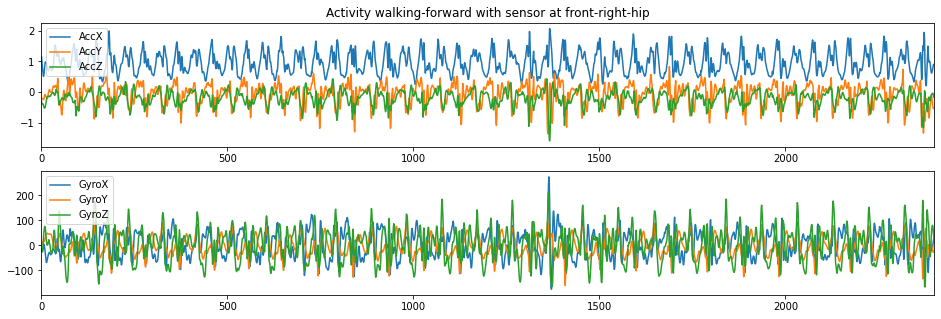

In [72]:
fig, ax = plt.subplots(2,1, figsize=(16, 5))
df[["AccX", "AccY", "AccZ"]].plot(ax=ax[0])
df[["GyroX", "GyroY", "GyroZ"]].plot(ax=ax[1])
ax[0].legend(ncol=1, loc=2)
ax[1].legend(ncol=1, loc=2)
ax[0].set_xlim(0, len(df))
ax[1].set_xlim(0, len(df))
ax[0].set_title(f"Activity {mat['activity'][0]} with sensor at {mat['sensor_location'][0]}")

plt.savefig("./figures/16_data.png", dpi=500, bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [93]:
TIME_OF_WINDOW = 2 # seconds
WINDOW_LENGTH = int(TIME_OF_WINDOW/FPS)

## Single RNN Layer

In [129]:
inputs = tf.keras.layers.Input(shape=(WINDOW_LENGTH, 3), name="Input")
x = tf.keras.layers.SimpleRNN(32, name="RNN")(inputs)
prediction = tf.keras.layers.Dense(len(classes), activation='softmax', name="Output")(x)

model_functional = tf.keras.Model(inputs=inputs, outputs=prediction)

model_functional.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 200, 3)]          0         
_________________________________________________________________
RNN (SimpleRNN)              (None, 32)                1152      
_________________________________________________________________
Output (Dense)               (None, 12)                396       
Total params: 1,548
Trainable params: 1,548
Non-trainable params: 0
_________________________________________________________________


## Two-layer RNN Layer

In [127]:
inputs = tf.keras.layers.Input(shape=(WINDOW_LENGTH, 3), name="Input")
x = tf.keras.layers.SimpleRNN(32, name="RNN_1", return_sequences=True)(inputs)
x = tf.keras.layers.SimpleRNN(32, name="RNN_2")(x)
prediction = tf.keras.layers.Dense(len(classes), activation='softmax', name="Output")(x)

model_functional = tf.keras.Model(inputs=inputs, outputs=prediction)

model_functional.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 200, 3)]          0         
_________________________________________________________________
RNN_1 (SimpleRNN)            (None, 200, 32)           1152      
_________________________________________________________________
RNN_2 (SimpleRNN)            (None, 32)                2080      
_________________________________________________________________
Output (Dense)               (None, 12)                396       
Total params: 3,628
Trainable params: 3,628
Non-trainable params: 0
_________________________________________________________________


## LSTM Model

In [128]:
inputs = tf.keras.layers.Input(shape=(WINDOW_LENGTH, 3), name="Input")
x = tf.keras.layers.LSTM(32, name="LSTM_1", return_sequences=True)(inputs)
x = tf.keras.layers.LSTM(32, name="LSTM_2")(x)
prediction = tf.keras.layers.Dense(len(classes), activation='softmax', name="Output")(x)

model_functional = tf.keras.Model(inputs=inputs, outputs=prediction)

model_functional.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 200, 3)]          0         
_________________________________________________________________
LSTM_1 (LSTM)                (None, 200, 32)           4608      
_________________________________________________________________
LSTM_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
Output (Dense)               (None, 12)                396       
Total params: 13,324
Trainable params: 13,324
Non-trainable params: 0
_________________________________________________________________
